In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
import shap
from mplsoccer.pitch import Pitch, add_image
from scipy.ndimage import gaussian_filter
from sklearn.inspection import permutation_importance
from sklearn.decomposition import NMF
from PIL import Image
from urllib.request import urlopen
from pdpbox import pdp
from matplotlib import rcParams
from matplotlib.cm import get_cmap
from PIL import Image
from urllib.request import urlopen
from matplotlib.colors import ListedColormap

Set font size for charts

In [2]:
#labelsize = 15
#rcParams['xtick.labelsize'] = labelsize
#rcParams['ytick.labelsize'] = labelsize 

Load model and data

In [3]:
df_lgbm = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))
df_all = pd.read_parquet(os.path.join('..', 'data', 'shots.parquet'))
df_X = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
df_xg = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'xg_shap.parquet'))
model = load(os.path.join('..', 'models', 'lgbm_model.joblib'))
STATSBOMB = os.path.join('..', 'data', 'statsbomb')
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_freeze = pd.read_parquet(os.path.join(STATSBOMB, 'freeze.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

Load StatsBomb logos

In [4]:
logo_regular = np.array(Image.open('SB_Regular.png'))
logo_alt = np.array(Image.open('SB_Regular_Alt.png'))

Add Jersey number to freeze frame

In [5]:
df_statsbomb_freeze = df_statsbomb_freeze.merge(df_statsbomb_lineup[['match_id', 'player_id', 'player_jersey_number']],
                                                how='left', on=['match_id', 'player_id'], validate='m:1')

Add on Xg to original shots dataframe

In [6]:
df_all = df_all.merge(df_xg.loc[df_xg.statsbomb_id.notnull(), ['match_id', 'statsbomb_id', 'xg']], how='left')
df_all = df_all.merge(df_xg.loc[df_xg.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']], how='left', 
                      on=['match_id', 'wyscout_id'], suffixes=['', '_1'])
df_all.loc[df_all.xg.isnull(), 'xg'] = df_all.loc[df_all.xg.isnull(), 'xg_1']
df_all.drop('xg_1', axis=1, inplace=True)

Add on StatsBomb xG

In [7]:
df_statsbomb_shots = df_statsbomb_event.loc[df_statsbomb_event.type_name == 'Shot', ['id', 'shot_statsbomb_xg']].copy()
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all = df_all.merge(df_statsbomb_shots, left_on='statsbomb_id', right_on='statsbomb_id', how='left')

Compare StatsBomb xG and model

In [8]:
df_all['xg_difference'] = df_all.shot_statsbomb_xg - df_all.xg

In [9]:
df_xg_diff = df_all.loc[df_all['xg_difference'].notnull(), ['x', 'y', 'xg_difference']]

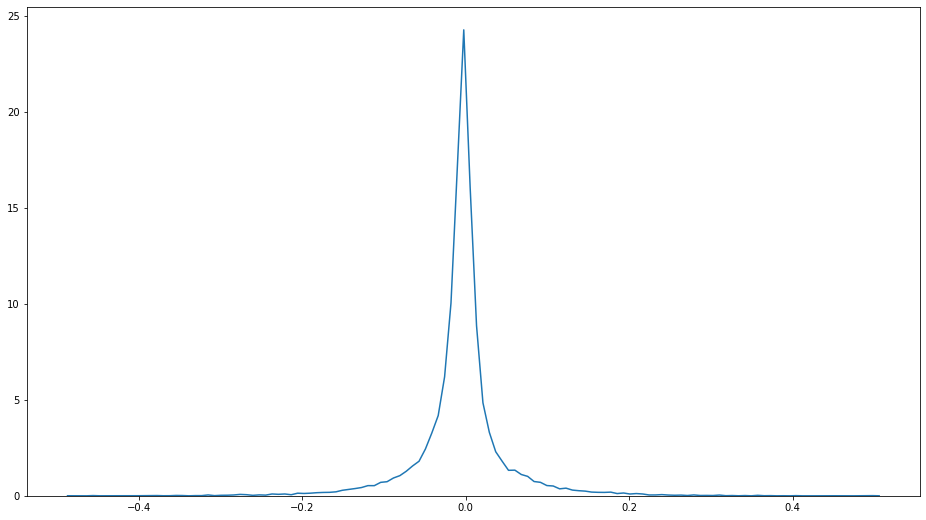

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(df_all['xg_difference'].values)
fig.savefig(os.path.join('figures', 'model_comparison_with_statsbomb_xg_dist'), bbox_inches = 'tight', pad_inches = 0)

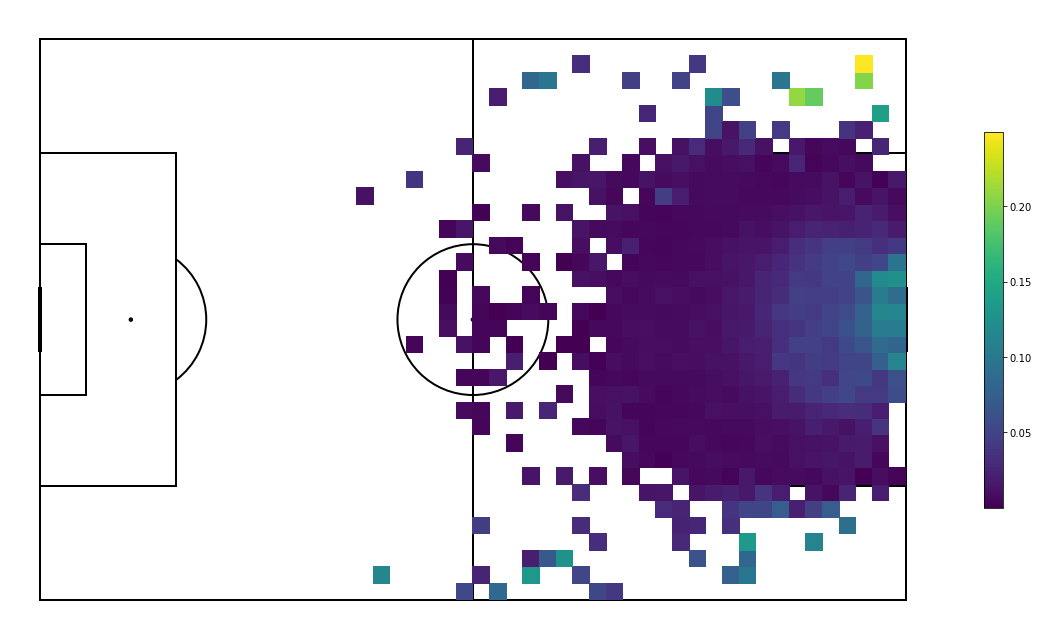

In [11]:
pitch = Pitch(pitch_type='statsperform', orientation='horizontal', figsize=(16, 9), line_color='black')
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df_xg_diff.x, df_xg_diff.y, values=np.abs(df_xg_diff.xg_difference), statistic='mean', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='None')
fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)
fig.savefig(os.path.join('figures', 'model_comparison_with_statsbomb_xg_map'), bbox_inches = 'tight', pad_inches = 0)

# Non-negative matrix facctorisation

mplsoccer pitch for plotting/ binning data

In [12]:
pitch = Pitch(pitch_type='statsperform', orientation='vertical', view='half',
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2, figsize=(16, 9))

Subset shots from players with more than 50 shots

In [13]:
shot_stats = df_all.player_id.value_counts()
player_ids = shot_stats[shot_stats >= 50].index
df_subset = df_all[df_all.player_id.isin(player_ids)].copy()
print('Number of shots:', len(df_subset))
n_players = len(player_ids)
print('Number of players:', n_players)

Number of shots: 27132
Number of players: 297


Overall shot map. Binning approximately 2 metre square grid. Count of shots in each grid cell.

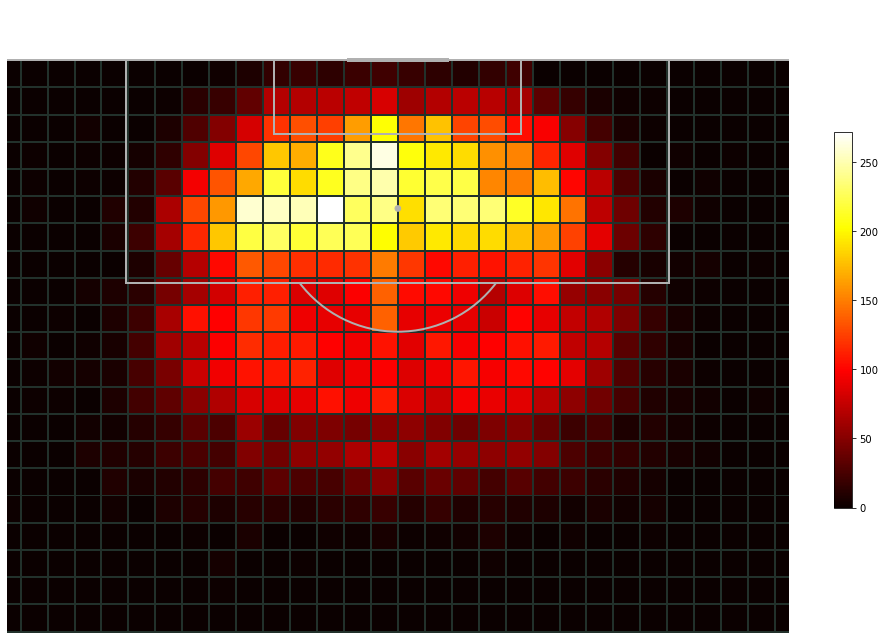

In [14]:
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df_subset.x, df_subset.y, statistic='count', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)

Bin Statistics for each player, smoothed with gaussian filter

In [15]:
results = np.zeros((n_players, 34 * 52))
for i in range(n_players):
    df_player = df_subset[df_subset.player_id == player_ids[i]]
    bs = pitch.bin_statistic(df_player.x, df_player.y, statistic='count', bins=(52, 34))
    results[i] = gaussian_filter(bs['statistic'], 1.5).flatten()

Non-negative matrix factorisation

In [16]:
m = NMF(n_components=5, init='random', random_state=42)
matrix = m.fit_transform(results)
df_matrix = pd.DataFrame(matrix, index=player_ids)
H = m.components_

Load the StatsBomb logo

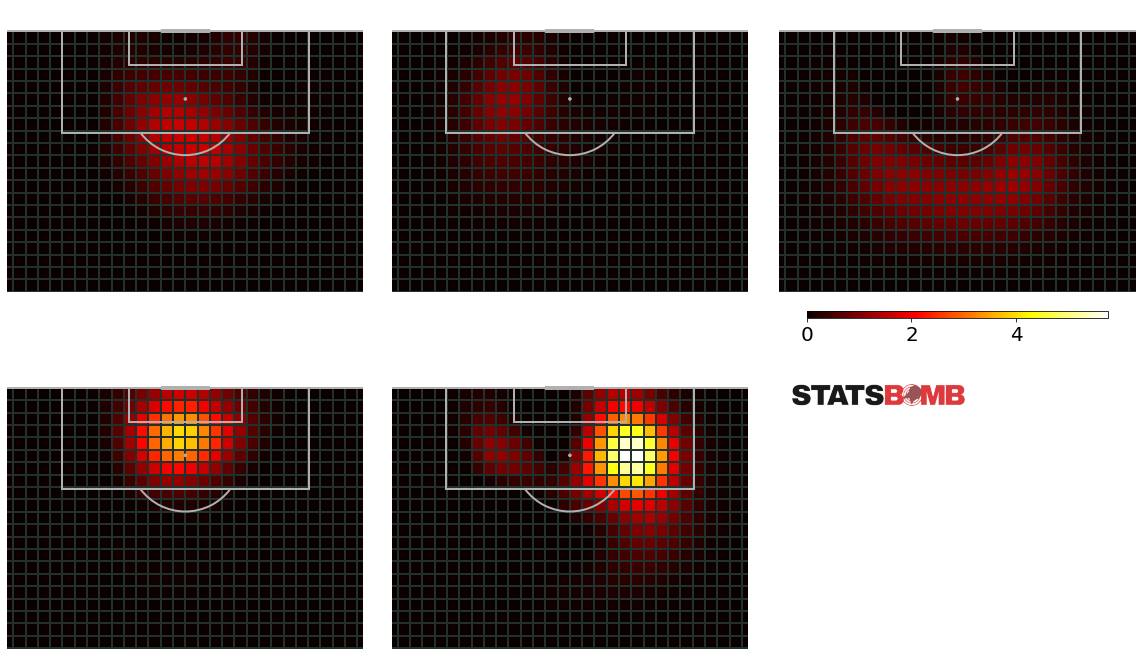

In [17]:
pitch = Pitch(pitch_type='statsperform', orientation='vertical', view='half',
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2, figsize=(16, 9),
             layout=(2, 3), tight_layout=False, constrained_layout=True)
fig, axs = pitch.draw()
axs[1, 2].remove()

bs['statistic'] = H[0].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[1].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[2].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 2], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[3].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[4].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

cbar = fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom', shrink=0.8)
cbar.ax.tick_params(labelsize=20) 

ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.38, width=0.15, alpha=0.9, interpolation='hanning')

fig.savefig(os.path.join('figures', 'non-negative-matrix-factorization-shot-locations.png'),
            dpi=300, bbox_inches = 'tight', pad_inches = 0)

# Permutation importance

In [18]:
perm_result = permutation_importance(model,
                                     df_X,
                                     df_lgbm.goal,
                                     n_repeats=10,
                                     random_state=42,
                                     n_jobs=-1)

In [19]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])

df_perm_importance = pd.DataFrame({'Feature': features,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)

In [20]:
df_perm_importance

,Feature,importance,std_dev
0,x,0.013597,0.000385
1,y,0.008259,0.000305
2,goalkeeper x,0.001007,0.000166
3,body part name,0.000796,0.000172
4,n angle,0.000782,0.000215
5,shot type name,0.000645,0.000210
6,assist type,0.000425,0.000126
7,shot open goal,0.000329,0.000066
8,pass height name,0.000316,0.000167
9,pass technique name,0.000246,0.000074


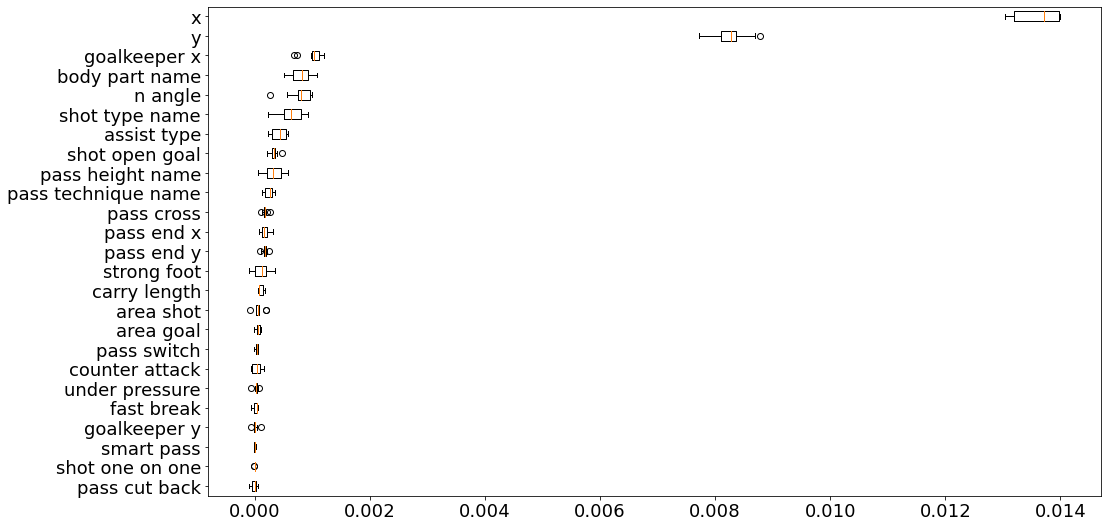

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
box_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=features[sorted_idx])
ax.tick_params(axis='both', which='major', labelsize=18)
fig.savefig(os.path.join('figures', 'model_perm_importance.png'), bbox_inches = 'tight', pad_inches = 0)

# Partial dependence plots

Custom grid for partial dependence plots (roughly 1 metres squared)

In [22]:
x = np.linspace(36, 105, 70)
y = np.linspace(0, 68, 69)

Partial dependence interactions calculations

In [23]:
mask_kick_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross == 1)
inter_kick_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_kick_cross], model_features=df_X.columns,
                                    features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)

In [24]:
mask_other_cross = (df_X.body_part_name == 2) & (df_X.pass_cross == 1)
inter_other_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_other_cross], model_features=df_X.columns,
                                     features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)

In [25]:
mask_kick_not_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross != 1)
inter_kick_not_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_kick_not_cross], model_features=df_X.columns,
                                        features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)

Partial dependence plots

In [26]:
def get_contour_values(inter, col1, col2, len1=len(x), len2=len(y)):
    df_inter = inter.pdp
    X = df_inter[col1].values.reshape((len1, len2)).T
    Y = df_inter[col2].values.reshape((len1, len2)).T
    Z = df_inter.preds.values.reshape((len1, len2)).T
    Z = Z * 100.
    return X, Y, Z    

In [27]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

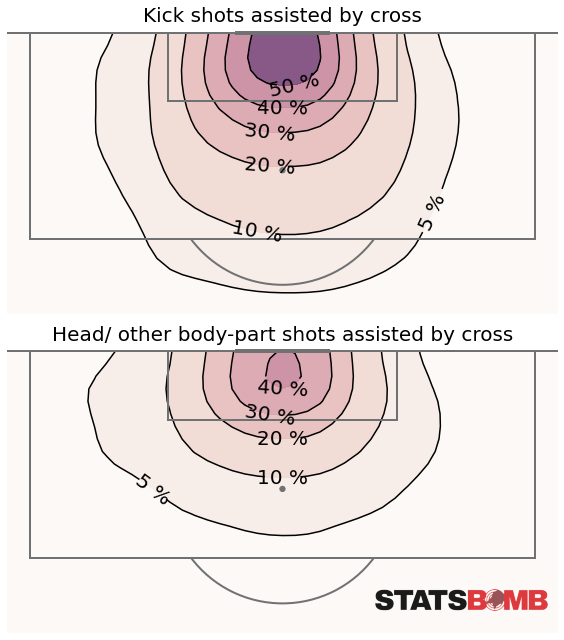

In [28]:
pitch = Pitch(pitch_type='statsperform', line_zorder=3, orientation='vertical', view='half', figsize=(16, 9), 
              pad_top=0.5, pad_left=-12, pad_bottom=-30, pad_right=-12,
              line_color='#707172', layout=(2, 1))
fig, ax = pitch.draw()
X, Y, Z = get_contour_values(inter_kick_cross, 'x', 'y')
# for visual purposes clear the events towards the side and blur
#Z[50:, :] = 2
#Z[:20, :] = 2
Z = gaussian_filter(Z, 1.5)
levels = np.array([0, 5, 10, 20, 30, 40, 50, 100])
contoursf = ax[0].contourf(Y, X, Z, cmap=cmap, levels=levels, alpha=0.9)
contours = ax[0].contour(Y, X, Z, levels=levels, colors='black')
labels = ax[0].clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax[0].set_title('Kick shots assisted by cross', fontsize=20, pad=5)

X, Y, Z = get_contour_values(inter_other_cross, 'x', 'y')
# for visual purposes clear the events towards the side and blur
#Z[50:, :] = 2
#Z[:20, :] = 2
Z = gaussian_filter(Z, 1.5)
contoursf = ax[1].contourf(Y, X, Z, levels=levels, cmap=cmap, alpha=0.9)
contours = ax[1].contour(Y, X, Z, levels=levels, colors='black')
labels = ax[1].clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax[1].set_title('Head/ other body-part shots assisted by cross', fontsize=20, pad=5)
ax_image = add_image(logo_regular, fig, left=0.58, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('figures', 'partial_dependence_probability_scoring_crosses.png'),
            bbox_inches = 'tight', pad_inches = 0)

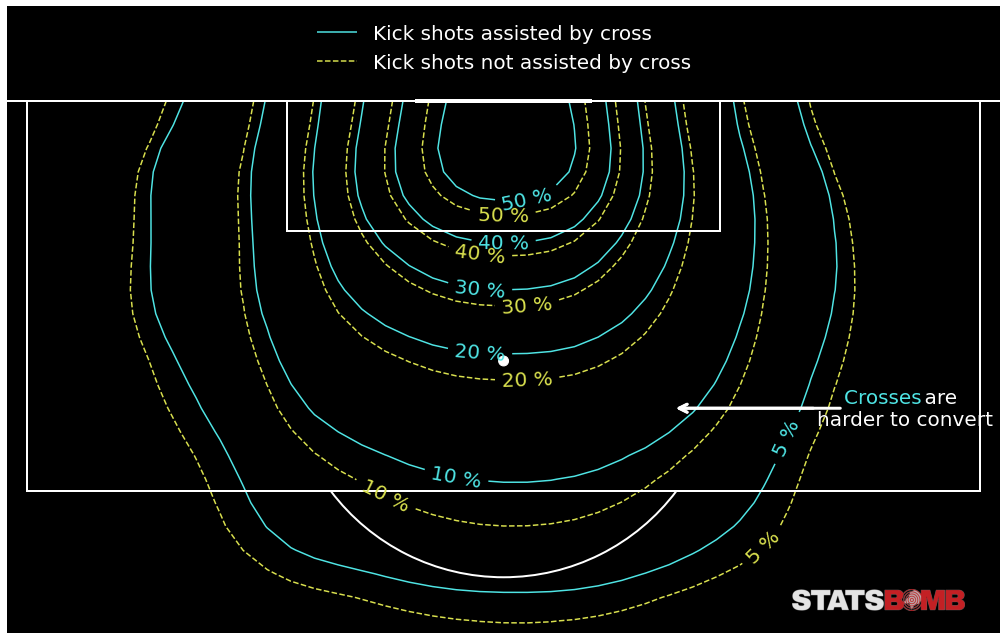

In [29]:
pitch = Pitch(pitch_type='statsperform', line_zorder=3, orientation='vertical', view='half', figsize=(16, 9),
             pad_left=-13, pad_bottom=-30, pad_right=-13, line_color='#FFFFFF', pitch_color='black')
fig, ax = pitch.draw()

levels = np.array([0, 5, 10, 20, 30, 40, 50])
X, Y, Z = get_contour_values(inter_kick_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour1 = ax.contour(Y, X, Z, levels=levels, colors='#4fe4e4')
labels1 = ax.clabel(contour1, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#4fe4e4')

X, Y, Z = get_contour_values(inter_kick_not_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='#d9e04e', linestyles='--')
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#d9e04e')

h1,_ = contour1.legend_elements()
h2,_ = contour2.legend_elements()
legend = ax.legend([h1[-1], h2[-1]], ['Kick shots assisted by cross', 'Kick shots not assisted by cross'],
                   fontsize=20, frameon=False, loc='upper center')
for text in legend.get_texts():
    text.set_color("white")
    
ax.annotate("            are \nharder to convert", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='white', fontsize=20)
ax.annotate("Crosses       \n                 ", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='#4fe4e4', fontsize=20)
ax_image = add_image(logo_alt, fig, left=0.75, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('figures', 'partial_dependence_probability_scoring_kick_shots.png'),
            bbox_inches = 'tight', pad_inches = 0)

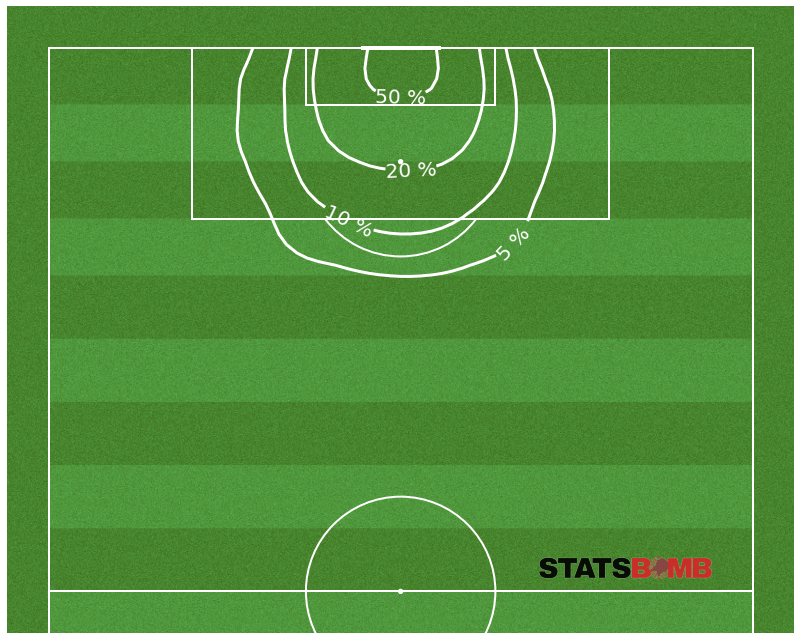

In [30]:
pitch = Pitch(pitch_type='statsperform', line_zorder=3, orientation='vertical', view='half', figsize=(16, 9),
              line_color='#FFFFFF', pitch_color='grass', stripe=True)
fig, ax = pitch.draw()
levels = np.array([0, 5, 10, 20, 50])
X, Y, Z = get_contour_values(inter_kick_not_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='white', linestyles='-', linewidths=3)
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='white')
ax_image = add_image(logo_regular, fig, left=0.62, bottom=0.1, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('figures', 'probability_scoring_kick_not_cross.png'),
            bbox_inches = 'tight', pad_inches = 0)

In [31]:
n_angle_isolate = pdp.pdp_isolate(model, dataset=df_X[df_X.n_angle.notnull()],
                                  model_features=df_X.columns, feature='n_angle')

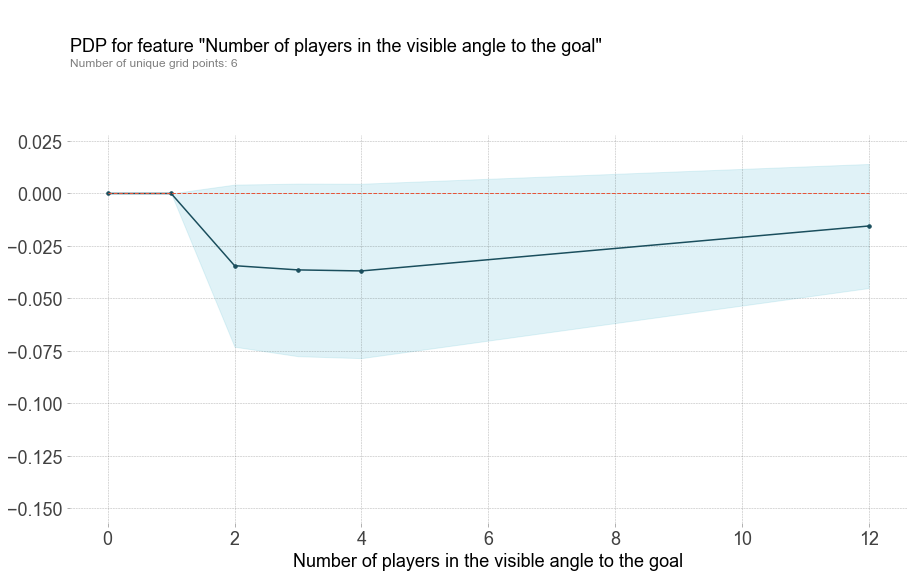

In [32]:
fig, ax = pdp.pdp_plot(n_angle_isolate, 'Number of players in the visible angle to the goal',
                      plot_params={'title_fontsize': 18})
ax['pdp_ax'].tick_params(axis='both', which='major', labelsize=18)
ax['pdp_ax'].set_xlabel('Number of players in the visible angle to the goal', fontsize=18)
fig.savefig(os.path.join('figures', 'partial_dependence_plot_example.png'), bbox_inches = 'tight', pad_inches = 0)

# Shap values

Filter only StatsBomb and add goalkeeper id

In [33]:
df_xg = df_xg.loc[df_xg['statsbomb_id'].notnull()].copy()
df_xg = df_xg.merge(df_all.loc[df_all.statsbomb_id.notnull(), ['statsbomb_id','player_id_goalkeeper']],
                    how='left', on='statsbomb_id', validate='1:1')
df_xg.drop('wyscout_id', axis=1, inplace=True)

Add nickname

In [34]:
df_statsbomb_lineup = df_statsbomb_lineup[['player_id', 'player_nickname', 'player_name']]
df_statsbomb_lineup.sort_values('player_nickname', inplace=True)
mask_nickname = df_statsbomb_lineup.player_nickname.isnull()
df_statsbomb_lineup.loc[mask_nickname, 'player_nickname'] = df_statsbomb_lineup.loc[mask_nickname, 'player_name']
df_statsbomb_lineup.drop_duplicates('player_id', keep='first', inplace=True)
df_statsbomb_lineup.drop('player_name', axis=1, inplace=True)
df_xg = df_xg.merge(df_statsbomb_lineup, left_on='player_id_goalkeeper', right_on='player_id', how='left')

Dataframe of nicknames

In [35]:
df_statsbomb_event['outcome_name'] = df_statsbomb_event.outcome_name.replace({'Off T': 'Off Target'})

Filter goalkeeper

In [36]:
#df_xg = df_xg[df_xg.player_nickname == 'Iker Casillas']

Add Shap values for goalkeeper position

In [37]:
df_xg['gk_contribution'] = df_xg[['goalkeeper x', 'goalkeeper y']].sum(axis=1).sort_values()

Sort values by contribution

In [38]:
df_xg.sort_values('gk_contribution', inplace=True)

In [39]:
idx = -3

In [40]:
shot_id = df_xg.iloc[idx].statsbomb_id
df_single_shot = df_statsbomb_event[df_statsbomb_event.id == shot_id].copy()
df_single_shot = df_single_shot.merge(df_statsbomb_lineup, how='left', on='player_id')
df_single_frame = df_statsbomb_freeze[df_statsbomb_freeze.id == shot_id].copy()
df_single_frame = df_single_frame.merge(df_statsbomb_lineup, how='left', on='player_id')

In [41]:
df_teammate = df_single_frame[df_single_frame.player_teammate].copy()
df_gk = df_single_frame[(~df_single_frame.player_teammate) & 
                        (df_single_frame.player_position_name == 'Goalkeeper')].copy()
df_other = df_single_frame[(~df_single_frame.player_teammate) & 
                           (df_single_frame.player_position_name != 'Goalkeeper')].copy()
outcome = df_single_shot.outcome_name.values[0]
team_name = df_single_shot.team_name.values[0]
player_name = df_single_shot.player_nickname.values[0]
if player_name is None:
    player_name = df_single_shot.player_name.values[0]
gk_name = df_gk.player_nickname.values[0]
if gk_name is None:
    gk_name = df_gk.player_name.values[0]
match_id = df_single_shot.match_id.values[0]

In [42]:
home_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].home_team_name.values[0]
away_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].away_team_name.values[0]
date = df_statsbomb_match[df_statsbomb_match.match_id == match_id].match_date.values[0].astype('str')[:10]
if home_team == team_name:
    other_team = away_team
else:
    other_team = home_team

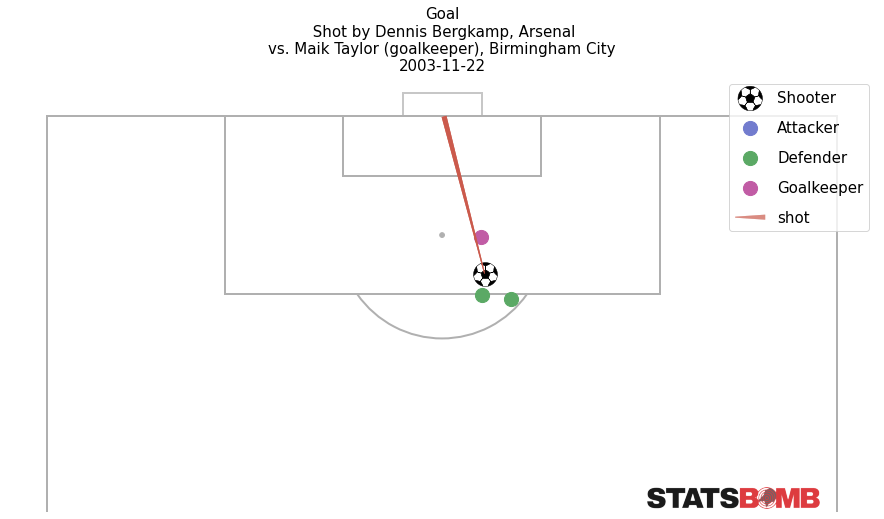

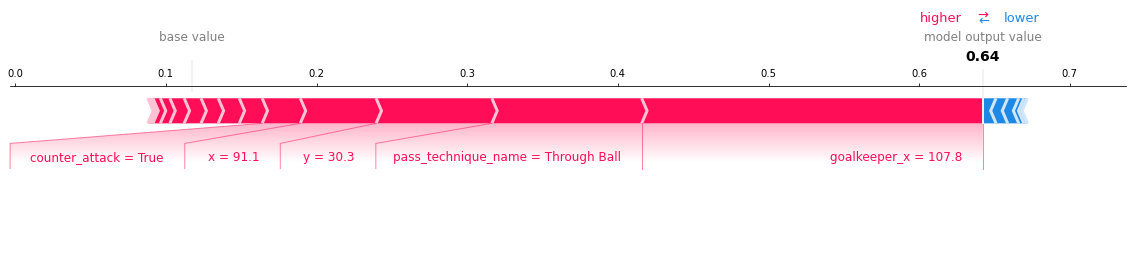

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))
pitch = Pitch(orientation='vertical', view='half', tight_layout=False, goal_type='box', pad_bottom=-20)
pitch.draw(ax=ax)
ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.13, width=0.15, alpha=0.9, interpolation='hanning')
sc1 = pitch.scatter(df_single_shot.x, df_single_shot.y, marker='football', s=600, ax=ax, label='Shooter', zorder=1.2)
sc2 = pitch.scatter(df_teammate.x, df_teammate.y, s=200, c='#727cce', label='Attacker', ax=ax)
sc3 = pitch.scatter(df_other.x, df_other.y, s=200, c='#5ba965', label='Defender', ax=ax)
sc4 = pitch.scatter(df_gk.x, df_gk.y, s=200, ax=ax, c='#c15ca5', label='Goalkeeper')
line = pitch.lines(df_single_shot.x, df_single_shot.y, 
                   df_single_shot.end_x, df_single_shot.end_y,
                   comet=True, label='shot', color='#cb5a4c', ax=ax)
legend = ax.legend(labelspacing=1, fontsize=15)
title = (f'{outcome}\n Shot by {player_name}, {team_name}\n'
         f'vs. {gk_name} (goalkeeper), {other_team}\n'
         f'{date}')
ax.set_title(title, fontsize=15)
features = df_all.loc[df_all.statsbomb_id == shot_id, df_X.columns]
float_cols = ['x', 'y', 'pass_end_x', 'pass_end_y', 'carry_length', 'area_shot',
              'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']
features[float_cols] = features[float_cols].round(1)
shap.force_plot(df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[-5]].values[0], 
                df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[3:-5]].values,
                features=features.astype(str),
                feature_names=df_X.columns, matplotlib=True)

In [44]:
df_all.loc[df_all.statsbomb_id == shot_id, ['shot_statsbomb_xg', 'xg', 'xg_difference']]

,shot_statsbomb_xg,xg,xg_difference
10820,0.367686,0.642252,-0.274566


In [45]:
df_xg[df_xg.statsbomb_id == shot_id].gk_contribution

10820    0.23136
Name: gk_contribution, dtype: float64

Average contributions

In [46]:
df_xg = df_xg.merge(df_statsbomb_match[['match_id', 'competition_gender']], on='match_id', how='left')
df_xg.loc[df_xg.competition_gender.isnull(), 'competition_gender'] = 'female'

In [47]:
df_xg['good_position'] = df_xg['gk_contribution'] <= -0.01
df_xg['poor_position'] = df_xg['gk_contribution'] >= 0.05

In [48]:
gk_200_shots = df_xg.player_id.value_counts()[df_xg.player_id.value_counts() >= 200].index
df_xg = df_xg[df_xg.player_id.isin(gk_200_shots)].copy()

In [49]:
gk_contribution = df_xg.groupby(['player_id', 'player_nickname', 'competition_gender'])['good_position', 'poor_position'].mean()
goal_counts = df_xg.groupby(['player_id', 'player_nickname', 'competition_gender']).player_id.count()
df_contribution = pd.DataFrame(gk_contribution).merge(pd.DataFrame(goal_counts), left_index=True, right_index=True)
df_contribution.rename({'player_id': 'shot_count'}, axis=1, inplace=True)
df_contribution.sort_values('good_position', ascending=False, inplace=True)
df_contribution['good_position'] = (df_contribution['good_position'] * 100).round(0)
df_contribution['poor_position'] = (df_contribution['poor_position'] * 100).round(0)
df_contribution.reset_index(drop=False, inplace=True)

In [50]:
df_contribution

,player_id,player_nickname,competition_gender,good_position,poor_position,shot_count
0,16376,Sophie Baggaley,female,48.0,5.0,592
1,15576,Kirstie Levell,female,46.0,2.0,263
2,6576,Gorka Iraizoz,male,45.0,11.0,256
3,15709,Megan Walsh,female,42.0,6.0,626
4,4691,Claudio Bravo,male,42.0,6.0,684
5,18158,Rebecca Spencer,female,41.0,5.0,387
6,4637,Ellie Roebuck,female,41.0,5.0,357
7,15719,Grace Moloney,female,39.0,12.0,336
8,19419,Marie Hourihan,female,38.0,6.0,213
9,25144,Diego Alves,male,38.0,9.0,278
